# Coin-M BTC DCA Ladder Strategy: Assumptions, Execution, and Robustness

This notebook implements and evaluates a Dollar-Cost-Averaging (DCA) ladder strategy on Bitcoin using coin-margined perpetual futures mechanics.

Key features:
- Deterministic fills (no randomness)
- Coin-margined funding fees applied in coin units
- Liquidation derived from wallet balance and maintenance margin
- Dynamic leverage cap tied to wallet balance
- Commissions and slippage costs
- Performance and risk metrics (Sharpe, Sortino, Calmar, Max Drawdown, VaR/ES)
- Clean plots and cycle-level reporting

### 1) Quick start

- Run all cells top-to-bottom to reproduce the in-sample (IS) and out-of-sample (OOS) results.
- Inputs
  - Data: BTC-USD daily OHLC from BTC-USD_Historical.csv (2015+)
  - Funding: constant daily rate unless a series is provided
- Outputs
  - Summary metrics (Sharpe, Sortino, Calmar, MDD, VaR/ES)
  - Equity curve + drawdowns
  - Cycle-level diagnostics (start/liquidation thresholds)

In [1]:
import math
from dataclasses import dataclass
from typing import Optional, Dict, Any, List, Tuple
from itertools import product

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from cycles import compute_previous_cycle_ath, compute_objective_end_date, next_halving_date

from buying_strategy import ladder
from metrics import compute_drawdowns, sortino_ratio, sharpe_ratio, lo_variance_inflation, adjusted_sharpe_lo, summarize_performance, var_es
from engine import run_backtest
from config import StrategyConfig


  ### 2) Data & preprocessing

- Source: BTC-USD daily OHLC (CSV). Columns used: Date, Open, High, Low, Close.
- Date handling: parsed to UTC-like daily timestamps and sorted.
- History window: clipped to >= 2015-01-01 to support long SMAs and prior-cycle ATH logic.
- Note: If you prefer live retrieval, replace the CSV load with a yfinance download cell (and save to CSV for reproducibility).

In [2]:
# Load full history once
PRICE_CSV_PATH = "BTC-USD_Historical.csv"  # adjust path as needed
price_all = pd.read_csv(PRICE_CSV_PATH)
price_all['Date'] = pd.to_datetime(price_all['Date'])
price_all = price_all.sort_values('Date').reset_index(drop=True)

price_all.head()

# Set the cycle start (e.g., halving date for the IS cycle)
START_DATE = pd.Timestamp('2020-05-11')

# Ensure enough history before START_DATE to compute long weekly SMA and prior-cycle ATH
price_all = price_all[price_all['Date'] >= '2015-01-01'].sort_values('Date').reset_index(drop=True)

price_all.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-10-24,276.503998,281.705994,276.503998,281.653992,281.653992,25942400
1,2015-10-25,281.445007,294.058990,281.445007,283.679993,283.679993,45717100
2,2015-10-26,283.627991,285.299988,280.510010,285.299988,285.299988,32108800
3,2015-10-27,285.181000,296.212006,285.007996,293.787994,293.787994,46331800
4,2015-10-28,293.703003,306.330994,293.703003,304.618011,304.618011,50808100


### 3) Cycle windows (IS & OOS)

- In-sample (IS): from START_DATE (e.g., halving) to an objective end date derived from:
  - Prior-cycle ATH and a weekly SMA regime filter (configurable)
- Out-of-sample (OOS): from the next halving date to +6 months (clipped to available data)
- Rationale: avoids using future information for IS and provides a clean, time-based OOS check.

In [3]:
END_DATE = compute_objective_end_date(price_all, START_DATE, weekly_sma_window=150, weekly_rule='W-SUN')

# Build IS window (this cycle only)
price = price_all[(price_all['Date'] >= START_DATE) & (price_all['Date'] <= END_DATE)].reset_index(drop=True)
print(f"Backtest IS window: {price['Date'].iloc[0].date()} -> {price['Date'].iloc[-1].date()} (objective end-date)")

# Halving dates (UTC close-of-day approximations). Adjust if you prefer exchange timestamps.
HALVING_DATES = [
    pd.Timestamp('2012-11-28'),
    pd.Timestamp('2016-07-09'),
    pd.Timestamp('2020-05-11'),
    pd.Timestamp('2024-04-20'),  # 2024 halving (approx)
]

OOS_START_DATE = next_halving_date(START_DATE, HALVING_DATES)
if OOS_START_DATE is None:
    print("No halving after START_DATE found in HALVING_DATES; OOS window cannot be built.")
    price_oos = pd.DataFrame()
else:
    OOS_END_DATE = OOS_START_DATE + pd.DateOffset(months=6)
    last_available = price_all['Date'].max()
    if OOS_START_DATE > last_available:
        print(f"OOS start {OOS_START_DATE.date()} is beyond available data ending {last_available.date()}. OOS window empty.")
        price_oos = pd.DataFrame()
    else:
        # Clip OOS end to available data
        OOS_END_DATE = min(OOS_END_DATE, last_available)
        price_oos = price_all[(price_all['Date'] >= OOS_START_DATE) & (price_all['Date'] <= OOS_END_DATE)].reset_index(drop=True)
        print(f"OOS window: {price_oos['Date'].iloc[0].date()} -> {price_oos['Date'].iloc[-1].date()} (next halving + 6 months)")

Objective end-date rule: prev cycle ATH=19,497.40 USD; end_date=2021-10-24
Backtest IS window: 2020-05-11 -> 2021-10-24 (objective end-date)
OOS window: 2024-04-20 -> 2024-10-20 (next halving + 6 months)


### 4) Configuration guide

Key parameters (see fields in StrategyConfig):
- initial_margin_btc: Seed collateral (BTC) per cycle
- leverage_limit: Max leverage multiple for sizing
- open_margin_pct: Fraction of initial margin used for the first entry
- take_profit_pct: Close the position when gain ≥ this fraction
- commission_rate, slippage_bps: Applied to every fill (entry/scale/exit)
- constant_funding_daily: Daily funding (fallback if no series is supplied)
- maintenance_margin_rate: Used in liquidation calculations
- stop_on_liquidation: Stop trading for the cycle if liquidation occurs
- forced_close_on_last_day: Force an exit on the last day of the window
- contract_model: 'inverse' (BTC-margined perp) or 'linear' (simplified path)

### 5) Contract mechanics (summary)

- Inverse perps (default):
  - Track USD notional q and entry E; unrealized PnL in BTC is q·(1/E − 1/P)
  - Funding and commission are deducted in BTC terms
  - Liquidation price uses wallet BTC excl. unrealized PnL and maintenance margin
- Linear (legacy simplified path):
  - Track position size in BTC; unrealized PnL ≈ size·(P − E)/P
- Execution model:
  - Deterministic fills (close-based by default) with slippage & commission applied
  - Optional T+1 execution can be added if desired to remove any look-ahead doubt

### 6) Backtest execution flow

Per day within a cycle:
1) If not in a position: seed wallet with initial_margin_btc and open using open_margin_pct
2) Apply funding (BTC) per model and rate
3) Recompute liquidation price; if Low ≤ liq_price, mark liquidation and (optionally) stop
4) Apply ladder rules for scale-in (buying_strategy.ladder)
5) Check take-profit and end-of-window forced close
6) Record daily equity, PnL, leverage, and diagnostics

Notes:
- Slippage + commission are applied to all entries and exits (including ladder adds).
- Liquidation logic is an approximation of exchange mechanics.

### 7) Performance metrics

Reported (daily):
- Sharpe, Sortino (downside risk), Calmar (CAGR/MDD), Max Drawdown
- Tail risk: VaR and ES (95%)
- Lo-adjusted Sharpe: corrects for serial correlation (variance inflation)
Outputs:
- IS and OOS summaries printed; CSV saved under results/ if enabled

In [54]:
cfg = StrategyConfig(
    initial_margin_btc=1.0,
    leverage_limit=1.3,
    open_margin_pct=0.02,
    take_profit_pct=0.2,
    commission_rate=0.0004,
    slippage_bps=0.5,
    constant_funding_daily=0.1/365.0,
    maintenance_margin_rate=0.005,
    stop_on_liquidation=True,
    forced_close_on_last_day=True,
    deterministic_fills=True,
    contract_model='inverse'  # explicit
)

res = run_backtest(price, cfg)

perf = res['perf'].copy()
status = res.get('status', {})
cycles = res.get('cycles', [])

summary = summarize_performance(perf)
summary

start_liq_price 4886.438371141591
start_liq_price 6199.268020041854
start_liq_price 7365.558423613164
start_liq_price 8842.539210408946
start_liq_price 10590.128027396802
start_liq_price 13144.024979192172
start_liq_price 16475.062015668584
start_liq_price 22365.582413936438
start_liq_price 26404.60898832027
start_liq_price 31868.559551605
start_liq_price 33687.978395036895
start_liq_price 25895.574421865826
start_liq_price 30565.66672255078
start_liq_price 35339.84931920227


{'Date': Timestamp('2020-05-11 00:00:00'),
 'Close': 8601.7958984375,
 'Equity_USD': 8601.522384658829,
 'Free_Margin_BTC': 0.9699772763561644,
 'Spot_BTC': 0.0,
 'Pos_Margin_BTC': 0.029992876356164384,
 'Pos_Q_USD': 335.48681354106446,
 'Base_Equity_BTC': 0.9999701527123288,
 'Unreal_PnL_BTC': -1.9499999999909033e-06,
 'Unreal_PnL_USD': -0.016773502001874878,
 'Avg_Entry': 8602.22598823242,
 'Liq_Price': 324.51774165847877,
 'Liq_Price_Pre': 4887.1952110989605,
 'Liq_Price_Post': 324.51774165847877,
 'Wallet_BTC_Excl_Unreal': 0.9999701527123288,
 'Q_over_Entry_BTC': 0.039000000000000014,
 'Liq_Denom_BTC_Pre': 0.045992876356164385,
 'Liq_Denom_BTC_Post': 1.0389701527123287,
 'MM_BTC_at_Mark': 0.0001300065,
 'Cycle': 1}

### 8) Plots & interpretation

- Equity curve with drawdown region
- Optionally annotate major cycle boundaries and liquidation points
- Interpretation guide:
  - Smooth, consistent equity growth across IS → OOS is preferred
  - Watch for concentration of gains (few big days) and long drawdown tails
  - Validate that TP events and scale-ins align with the ladder logic

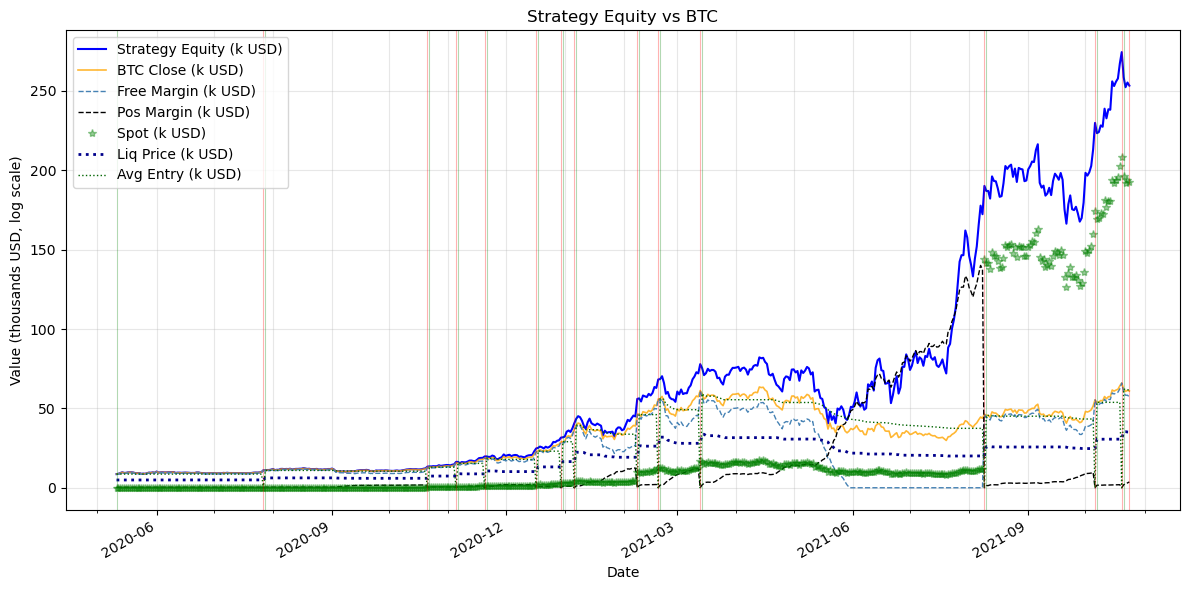

In [55]:
if not perf.empty:
    plt.figure(figsize=(12, 6))
    # Normalize equity and BTC price for a visual compare (scale to thousands for readability)
    plt.plot(perf['Date'], perf['Equity_USD'] / 1000.0, label='Strategy Equity (k USD)', color='blue', linewidth=1.5)
    plt.plot(perf['Date'], perf['Close'] / 1000.0, label='BTC Close (k USD)', color='orange', linewidth=1.2, alpha=0.8)

    # Components
    plt.plot(perf['Date'], (perf['Free_Margin_BTC'] * perf['Close']) / 1000.0,
             '--', label='Free Margin (k USD)', color='steelblue', linewidth=1.0)
    plt.plot(perf['Date'], (perf['Pos_Margin_BTC'] * perf['Close']) / 1000.0,
             '--', label='Pos Margin (k USD)', color='black', linewidth=1.0)
    plt.plot(perf['Date'], (perf['Spot_BTC'] * perf['Close']) / 1000.0,
             '*', label='Spot (k USD)', color='green', alpha=0.4, linewidth=0.3)

    # Liq and average entry (scaled)
    plt.plot(perf['Date'], perf['Liq_Price_Pre'] / 1000.0, ':', label='Liq Price (k USD)', color='darkblue', linewidth=2.0)
    plt.plot(perf['Date'], perf['Avg_Entry'] / 1000.0, ':', label='Avg Entry (k USD)', color='darkgreen', linewidth=1.0)

    # Cycle markers
    for d in status['starts']:
        plt.axvline(d, color='green', alpha=0.3, linewidth=0.8)
    for d in status['ends']:
        plt.axvline(d, color='red', alpha=0.3, linewidth=0.8)

    plt.title('Strategy Equity vs BTC')
    plt.xlabel('Date')

# ----------------- key changes -----------------
    ax = plt.gca()

    # 1) Logarithmic y-axis
    #ax.set_yscale('log')
    #ax.set_ylim(20, 45)          # corresponds to 5 k – 20 k on the original scale
    ax.set_ylabel('Value (thousands USD, log scale)')

    # 2) Denser time labels: major ticks every quarter, minor every month
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))      # Jan-Apr-Jul-Oct
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())                # all months
    # ------------------------------------------------

    plt.legend(loc='best')
    plt.grid(True, alpha=0.3, which='both')  # grid on major & minor ticks
    plt.gcf().autofmt_xdate()                # rotate & align labels nicely
    plt.tight_layout()
    plt.show()

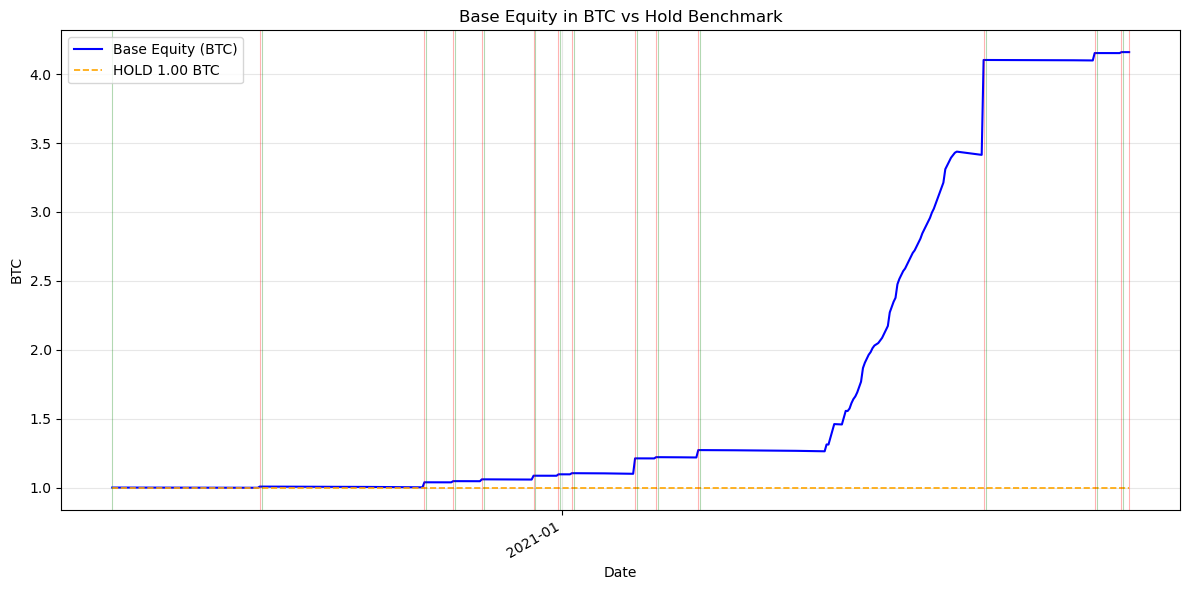

In [56]:
if not perf.empty:
    plt.figure(figsize=(12, 6))
    plt.plot(perf['Date'], perf['Base_Equity_BTC'], label='Base Equity (BTC)', color='blue', linewidth=1.5)
    plt.plot(perf['Date'], np.full(len(perf), cfg.initial_margin_btc), '--', label=f'HOLD {cfg.initial_margin_btc:.2f} BTC', color='orange', linewidth=1.2)

    for d in status['starts']:
        plt.axvline(d, color='green', alpha=0.3, linewidth=0.8)
    for d in status['ends']:
        plt.axvline(d, color='red', alpha=0.3, linewidth=0.8)

    plt.title('Base Equity in BTC vs Hold Benchmark')
    plt.xlabel('Date')
    plt.ylabel('BTC')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    ax = plt.gca()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()

In [37]:
if cycles:
    print("Cycle Details:")
    print("="*160)
    print(f"{'Cycle':<6} {'Start Date':<12} {'End Date':<12} {'Reason':<16} {'Days':<5} "
          f"{'Start Eq (BTC)':<15} {'End Eq (BTC)':<15} "
          f"{'Start Px':<12} {'End Px':<12} "
          f"{'Start Liq':<12} {'End Liq':<12} "
          f"{'ΔBTC':<12}")
    print("-"*160)
    for cy in cycles:
        if 'end_date' not in cy:
            continue
        start_eq_btc = cy['start_equity_btc_excl_unreal']
        end_eq_btc = cy['end_equity_btc_excl_unreal']
        btc_change = end_eq_btc - start_eq_btc
        start_liq = cy.get('start_liq_price', np.nan)
        end_liq = cy.get('last_liq_price', np.nan)
        print(f"{cy['cycle']:<6} "
              f"{cy['start_date'].strftime('%Y-%m-%d'):<12} "
              f"{cy['end_date'].strftime('%Y-%m-%d'):<12} "
              f"{cy.get('reason',''): <16} "
              f"{cy.get('duration_days',0):<5} "
              f"{start_eq_btc: <15.6f} "
              f"{end_eq_btc: <15.6f} "
              f"{cy['start_price']: <12.2f} "
              f"{cy['end_price']: <12.2f} "
              f"{(start_liq if pd.notna(start_liq) else float('nan')): <12.2f} "
              f"{(end_liq if pd.notna(end_liq) else float('nan')): <12.2f} "
              f"{btc_change:+.6f}")

Cycle Details:
Cycle  Start Date   End Date     Reason           Days  Start Eq (BTC)  End Eq (BTC)    Start Px     End Px       Start Liq    End Liq      ΔBTC        
----------------------------------------------------------------------------------------------------------------------------------------------------------------
1      2020-05-11   2020-06-01   TAKE-PROFIT      21    0.999990        1.005119        8602.23      10166.76     4715.58      300.53       +0.005129
2      2020-06-02   2020-07-27   TAKE-PROFIT      55    1.005110        1.066431        9530.28      10990.32     5224.33      2809.41      +0.061322
3      2020-07-28   2020-10-21   TAKE-PROFIT      85    1.066422        1.095238        10913.37     12823.05     5982.51      1517.93      +0.028816
4      2020-10-22   2020-11-05   TAKE-PROFIT      14    1.095228        1.102921        12966.54     15579.07     7108.02      546.94       +0.007693
5      2020-11-06   2020-11-18   TAKE-PROFIT      12    1.102911       

In [29]:
def make_cfg(base_cfg: StrategyConfig, **overrides) -> StrategyConfig:
    # Create a copy with selected overrides
    params = base_cfg.__dict__.copy()
    params.update(overrides)
    return StrategyConfig(**params)

# Define a compact but meaningful grid. Keep it small to avoid overfitting and runtime blowups.
param_grid = {
    'leverage_limit': [2, 2.5, 3, 3.5, 4, 5, 6, 7, 8, 9, 10],
    'take_profit_pct': [0.04, 0.05, 0.06, 0.08, 0.10],
    'open_margin_pct': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06],
    # Optional cost sensitivity (uncomment to include)
    # 'commission_rate': [0.0002, 0.0004, 0.0006],
    # 'slippage_bps': [0.2, 0.5, 1.0],
}

def grid_sweep(price_df: pd.DataFrame,
               base_cfg: StrategyConfig,
               param_grid: dict,
               primary_metric: str = 'Sharpe (Lo-Adj)',
               secondary_metric: str = 'CAGR (%)',
               penalty_on_dd: bool = False) -> pd.DataFrame:
    """
    Run a grid search over param_grid on price_df using base_cfg as defaults.
    Returns a DataFrame sorted by (primary_metric desc, secondary_metric desc).
    Optionally apply a soft penalty on large drawdowns in ranking.
    """
    keys = list(param_grid.keys())
    combos = list(product(*[param_grid[k] for k in keys]))
    rows = []

    for combo in combos:
        overrides = dict(zip(keys, combo))
        cfg = make_cfg(base_cfg, **overrides)
        res = run_backtest(price_df, cfg)
        perf = res['perf']
        summ = summarize_performance(perf)

        # Guard for empty or degenerate runs
        if not summ:
            continue

        rank_primary = summ.get(primary_metric, np.nan)
        rank_secondary = summ.get(secondary_metric, np.nan)
        max_dd = summ.get('Max Drawdown (%)', np.nan)

        # Optional: penalize large drawdowns in the ranking number (softly)
        if penalty_on_dd and not np.isnan(rank_primary) and not np.isnan(max_dd):
            # Example: subtract 0.005 * |MaxDD| from primary metric (tune as desired)
            rank_primary = rank_primary - 0.005 * abs(max_dd)

        row = {**overrides,
               'IS_' + primary_metric: rank_primary,
               'IS_' + secondary_metric: rank_secondary,
               'IS_Max Drawdown (%)': max_dd,
               'IS_Total Return (%)': summ.get('Total Return (%)', np.nan),
               'IS_Final Equity (USD)': summ.get('Final Equity (USD)', np.nan),
               'IS_Liquidated': res['status']['liquidated']}
        rows.append(row)

    results = pd.DataFrame(rows)
    if results.empty:
        print("No results from grid sweep.")
        return results

    results = results.sort_values(
        by=[f'IS_{primary_metric}', f'IS_{secondary_metric}'],
        ascending=[False, False]
    ).reset_index(drop=True)
    return results

# Run the grid sweep on IS
base_cfg = StrategyConfig(
    initial_margin_btc=1.0,
    leverage_limit=1.2,          # default; will be overridden by grid
    open_margin_pct=0.02,
    take_profit_pct=0.10,
    commission_rate=0.0004,
    slippage_bps=0.5,
    constant_funding_daily=0.10 / 365.0,
    maintenance_margin_rate=0.005,
    stop_on_liquidation=True,
    forced_close_on_last_day=True,
    deterministic_fills=True
)

price_is = price.copy()  # the entire IS window

grid_results_is = grid_sweep(
    price_df=price_is,
    base_cfg=base_cfg,
    param_grid=param_grid,
    primary_metric='Sharpe (Lo-Adj)',
    secondary_metric='CAGR (%)',
    penalty_on_dd=True  # softly prefer lower DD
)
grid_results_is

start_liq_price 5763.491412115722
start_liq_price 6521.919605066895
start_liq_price 6339.22620327539
start_liq_price 6385.287734752441
start_liq_price 6636.793707859863
start_liq_price 7311.957151844238
start_liq_price 7406.29184881201
start_liq_price 7892.8428255351555
start_liq_price 8034.528083271972
start_liq_price 7627.783069303711
start_liq_price 8592.301527190428
start_liq_price 8892.205642740235
start_liq_price 9470.057190123045
start_liq_price 10429.661632790037
start_liq_price 10933.478404400392
start_liq_price 11929.280359977538
start_liq_price 12490.92023744238
start_liq_price 12598.63859184082
start_liq_price 13010.091507208008
start_liq_price 15280.222586211914
start_liq_price 15730.574087036133
start_liq_price 17713.700504024408
start_liq_price 19432.1244287373
start_liq_price 21965.053900910156
start_liq_price 24673.557014607417
start_liq_price 27335.765001164058
start_liq_price 24674.229665425784
start_liq_price 25107.55551032226
start_liq_price 26066.60900747461
start

,leverage_limit,take_profit_pct,open_margin_pct,IS_Sharpe (Lo-Adj),IS_CAGR (%),IS_Max Drawdown (%),IS_Total Return (%),IS_Final Equity (USD),IS_Liquidated
0,2.0,0.04,0.01,NaN,NaN,NaN,NaN,NaN,True
1,2.0,0.04,0.02,NaN,NaN,NaN,NaN,NaN,True
2,2.0,0.04,0.03,NaN,NaN,NaN,NaN,NaN,True
3,2.0,0.04,0.04,NaN,NaN,NaN,NaN,NaN,True
4,2.0,0.04,0.05,NaN,NaN,NaN,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...
325,10.0,0.10,0.02,NaN,NaN,NaN,NaN,NaN,True
326,10.0,0.10,0.03,NaN,NaN,NaN,NaN,NaN,True
327,10.0,0.10,0.04,NaN,NaN,NaN,NaN,NaN,True
328,10.0,0.10,0.05,NaN,NaN,NaN,NaN,NaN,True


Best IS parameters: {'leverage_limit': 2.0, 'take_profit_pct': 0.04, 'open_margin_pct': 0.01}
start_liq_price 43548.45305597461
start_liq_price 43707.345218935545
start_liq_price 46993.825511296876
start_liq_price 43617.270207597656
start_liq_price 45665.813879660156
start_liq_price 43002.07476186328
start_liq_price 40205.44130436914
start_liq_price 42341.41126158985
start_liq_price 44146.93168934766
start_liq_price 44919.78915841406
start_liq_price 5763.491412115722
start_liq_price 6521.919605066895
start_liq_price 6339.22620327539
start_liq_price 6385.287734752441
start_liq_price 6636.793707859863
start_liq_price 7311.957151844238
start_liq_price 7406.29184881201
start_liq_price 7892.8428255351555
start_liq_price 8034.528083271972
start_liq_price 7627.783069303711
start_liq_price 8592.301527190428
start_liq_price 8892.205642740235
start_liq_price 9470.057190123045
start_liq_price 10429.661632790037
start_liq_price 10933.478404400392
start_liq_price 11929.280359977538
start_liq_price 

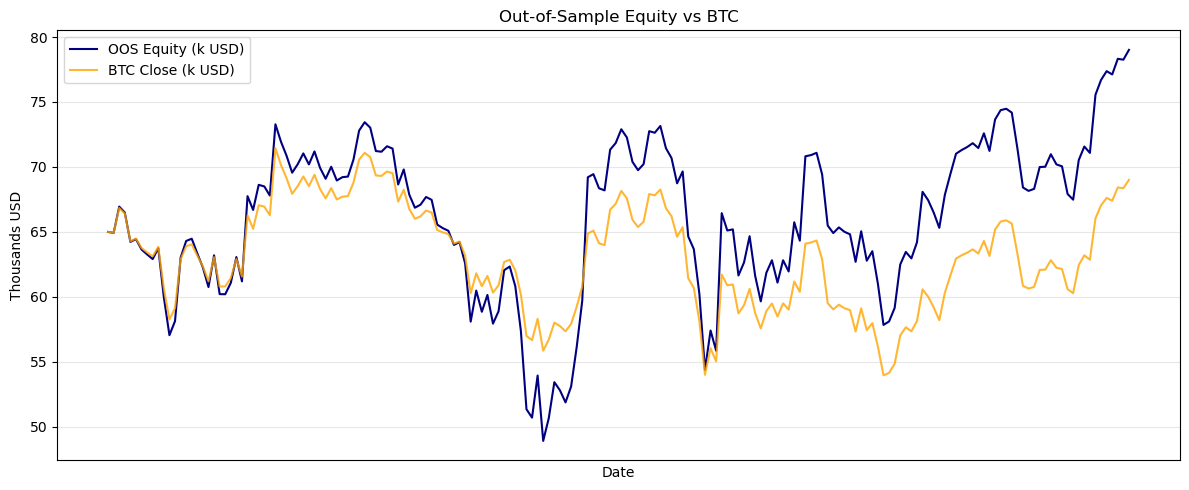

In [9]:
def pick_best_params(grid_df: pd.DataFrame) -> dict:
    if grid_df.empty:
        raise ValueError("Empty grid results; cannot pick best parameters.")
    # First row is best under our sort order
    keys = [k for k in grid_df.columns if k in param_grid.keys()]
    return grid_df.iloc[0][keys].to_dict()

if grid_results_is.empty:
    print("Grid results empty; cannot proceed to OOS.")
else:
    best_params = pick_best_params(grid_results_is)
    print("Best IS parameters:", best_params)

    # Evaluate on OOS (fresh run with same params)
    best_cfg_oos = make_cfg(base_cfg, **best_params)
    res_oos = run_backtest(price_oos, best_cfg_oos)
    perf_oos = res_oos['perf']
    summary_oos = summarize_performance(perf_oos)

    # For reference, also capture IS performance of best params (not the whole grid)
    best_cfg_is = make_cfg(base_cfg, **best_params)
    res_is_best = run_backtest(price_is, best_cfg_is)
    perf_is_best = res_is_best['perf']
    summary_is_best = summarize_performance(perf_is_best)

    print("\nBest Params — IS Performance")
    for k, v in summary_is_best.items():
        if isinstance(v, float):
            if 'Equity' in k:
                print(f"{k}: ${v:,.2f}")
            else:
                print(f"{k}: {v:.4f}")
        else:
            print(f"{k}: {v}")

    print("\nBest Params — OOS Performance")
    if not summary_oos:
        print("OOS period empty or invalid.")
    else:
        for k, v in summary_oos.items():
            if isinstance(v, float):
                if 'Equity' in k:
                    print(f"{k}: ${v:,.2f}")
                else:
                    print(f"{k}: {v:.4f}")
            else:
                print(f"{k}: {v}")

    # Optional: plot OOS equity
    if perf_oos is not None and not perf_oos.empty:
        plt.figure(figsize=(12, 5))
        plt.plot(perf_oos['Date'], perf_oos['Equity_USD'] / 1000.0, label='OOS Equity (k USD)', color='navy')
        plt.plot(perf_oos['Date'], perf_oos['Close'] / 1000.0, label='BTC Close (k USD)', color='orange', alpha=0.8)
        plt.title('Out-of-Sample Equity vs BTC')
        plt.xlabel('Date')
        plt.ylabel('Thousands USD')
        plt.legend(loc='best')
        plt.grid(True, alpha=0.3)
        ax = plt.gca()
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax.xaxis.set_major_locator(mdates.YearLocator())
        plt.gcf().autofmt_xdate()
        plt.tight_layout()
        plt.show()

### 9) Limitations & assumptions

- Liquidation formula is a simplified approximation (exchange-specific details vary)
- Funding defaults to a constant daily rate unless a historical series is provided
- Daily bars only; intraday path dependency (gap risk) is not modeled
- Close-based fills by default; T+1 execution can be enabled to remove look-ahead

### 10) Reproducibility & outputs

- Environment: Python 3.10+, NumPy, pandas, Matplotlib (see requirements.txt)
- Deterministic: no randomness in fills; results should be repeatable with same data
- Saved artifacts:
  - figures/: equity curve and drawdown plots (PNG)
  - results/: summary tables (CSV) for IS and OOS
- Data note: If BTC-USD_Historical.csv is absent, run the optional download cell to create it